In [1]:
import torch
import torchvision

from torch import optim

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import pandas as pd
from PIL import Image
from glob import glob

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

### Explore Segmentation files

In [2]:
scans_seg = glob('../data/lgg-mri-segmentation/kaggle_3m/*/*_mask*')
scans = []

for seg in scans_seg:
    scan = seg.replace('_mask', '')
    scans.append(scan)

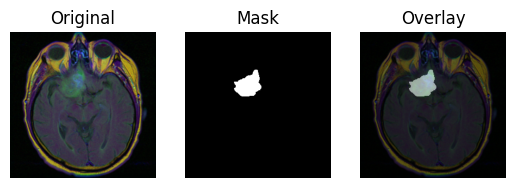

In [3]:
i = 1

scan_img = mpimg.imread(scans[i])
seg_img = mpimg.imread(scans_seg[i])

fig, ax = plt.subplots(1,3)

# Show images
ax[0].imshow(scan_img), ax[1].imshow(seg_img, cmap='gray')
ax[0].axis('off'), ax[1].axis('off'), ax[2].axis('off')

ax[0].set_title('Original'), ax[1].set_title('Mask'), ax[2].set_title('Overlay')

# Overlay
ax[2].imshow(scan_img), ax[2].imshow(seg_img, cmap='gray', alpha=0.5)

plt.show()

### Create Datasets

In [4]:
X_train, X_test, y_train, y_test = train_test_split(scans, scans_seg)

In [5]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

class BrainDataBase(Dataset):
    def __init__(self, X, y, Transform=None) -> None:
        super().__init__()
        self.scans = X
        self.segmentations = y
        self.transform = Transform

    def __len__(self):
        return len(self.scans)
    
    def __getitem__(self, idx):
        scan = self.scans[idx]
        segmentation = self.segmentations[idx]
        if self.transform:
            scan = self.transform(Image.open(scan))
            segmentation = self.transform(Image.open(segmentation))
        return scan, segmentation
    
# Datasets
train_set = BrainDataBase(X_train, y_train, transform)
test_set = BrainDataBase(X_test, y_test, transform)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(train_set, batch_size=32, shuffle=False)

### UNET nn

In [9]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)

Using cache found in C:\Users\timmi/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


In [6]:
def dice_loss(prediction, target, smooth=1e-6):
    intersection = torch.sum(prediction * target)
    cardinality = torch.sum(prediction) + torch.sum(target)
    dice = (2. * intersection + smooth) / (cardinality + smooth)
    return 1. - dice

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)
criterion = dice_loss

NameError: name 'model' is not defined

In [217]:
epoch_num = 1
running_loss = 0.
last_loss = 0.

for epoch in range(0, epoch_num):
    model.train()

    for x, y in tqdm(train_loader, desc='Training Model'):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        # Perform forward
        y_pred = model.forward(x)

        # Calculate loss
        loss = criterion(y_pred, y)
        loss.backward()

        optimizer.step()

    print(loss.detach().cpu().numpy())


Training Model:   0%|          | 0/93 [00:00<?, ?it/s]

0.26877594


In [10]:
model = torch.load('../models/model1.pkl')

In [12]:
for x, y in test_loader:
    break
y_pred = model.forward(x.to(device))

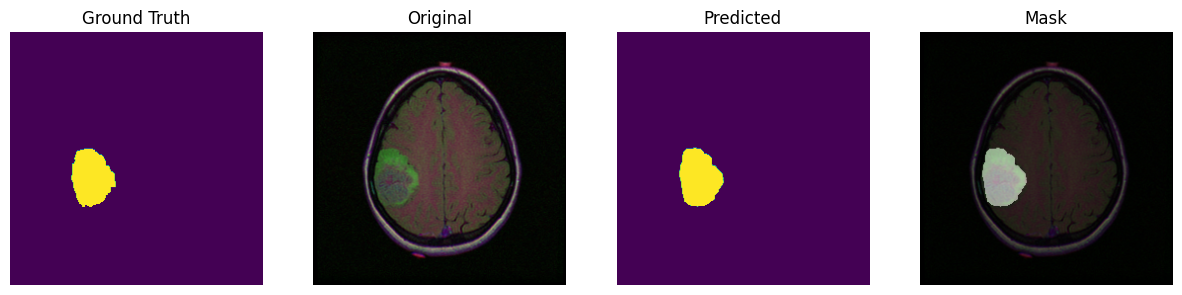

In [ ]:
i = 5
# Convert back to image
to_pil_image = transforms.ToPILImage()
x_image = to_pil_image(x[i])

# Convert back to image
to_pil_image = transforms.ToPILImage()
y_image = to_pil_image(y[i])

# Convert back to image
to_pil_image = transforms.ToPILImage()
pred_image = to_pil_image(y_pred[i])

fig, ax = plt.subplots(1,4, figsize=(15,70))
ax[0].imshow(y_image)
ax[0].axis('off')
ax[0].set_title('Ground Truth')

ax[1].axis('off')
ax[1].set_title('Original')
ax[1].imshow(x_image)

ax[2].axis('off')
ax[2].set_title('Predicted')
ax[2].imshow(pred_image)

ax[3].axis('off')
ax[3].set_title('Mask')
ax[3].imshow(x_image), ax[3].imshow(pred_image, alpha=0.5, cmap='gray')

plt.show()